In [2]:
import numpy as np

import requests
import re
import time
import os
import pandas as pd
import pickle

from bs4 import BeautifulSoup
from IPython.core.display import display, HTML
from selenium import webdriver
from selenium.webdriver.common.keys import Keys


import diagnostic_plots
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler

% matplotlib inline

/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
# use seaborn style for all plots
plt.style.use('seaborn')

In [4]:
# load from pickle files



filename_berkeley_clean = '/Users/xzhou/github/project_files/project_luther/professor_data_berkeley_cleaned.pkl'
filename_nyu_clean = '/Users/xzhou/github/project_files/project_luther/professor_data_nyu_cleaned.pkl' 
filename_uf_clean = '/Users/xzhou/github/project_files/project_luther/professor_data_uf_cleaned.pkl'

df_berkeley_clean=pd.read_pickle(filename_berkeley_clean)
df_nyu_clean=pd.read_pickle(filename_nyu_clean)
df_uf_clean=pd.read_pickle(filename_uf_clean)

In [5]:
print(df_berkeley_clean.shape)
print(df_nyu_clean.shape)
print(df_uf_clean.shape)

(1271, 29)
(2043, 29)
(1484, 29)


In [6]:
# define key for each section. This would be used for future references. 
dfs_clean=pd.concat([df_berkeley_clean, df_nyu_clean, df_uf_clean],keys=['berkeley', 'nyu', 'uf'])
dfs_clean.shape

(4798, 29)

In [7]:
# noted records with no professor name
dfs_clean.tail()

Rating  Level of difficulty  Total reviews  Student size  \
uf 5216     4.7                  3.3       1.791759         52367   
   5223     3.7                  3.0       1.791759         52367   
   5258     3.8                  2.8       1.386294         52367   
   5280     4.6                  2.6       3.218876         52367   
   5281     5.0                  3.2       1.386294         52367   

         Type_public  Type_private  Region_west  Region_east  Region_south  \
uf 5216            1             0            0            0             1   
   5223            1             0            0            0             1   
   5258            1             0            0            0             1   
   5280            1             0            0            0             1   
   5281            1             0            0            0             1   

         Accessible outside class      ...       Hilarious  Inspirational  \
uf 5216                      0.29      ...            0.06           0.06   
   5223                      0.27      ...            0.00           0.00   
   5258                      0.18      ...            0.00           0.00   
   5280                      0.17      ...            0.08           0.00   
   5281                      0.09      ...            0.00           0.09   

         Lecture heavy  Lots of homework  Participation matters  Respected  \
uf 5216           0.00              0.00                   0.06       0.06   
   5223           0.00              0.00                   0.00       0.18   
   5258           0.09              0.00                   0.00       0.00   
   5280           0.25              0.00                   0.08       0.00   
   5281           0.00              0.09                   0.09       0.18   

         Skip class? you won't pass.  So many papers  Test heavy  Tough grader  
uf 5216                         0.00             0.0        0.06          0.00  
   5223                         0.00             0.0        0.00          0.09  
   5258                         0.00             0.0        0.36          0.00  
   5280                         0.17             0.0        0.00          0.00  
   5281                         0.00             0.0        0.00          0.00  

[5 rows x 29 columns]

In [8]:
# Ran iterations of models and only keep key features that can impact rating

dfs_clean_smaller=dfs_clean.loc[:,['Rating', 'Level of difficulty',  
        'Accessible outside class', 'Amazing lectures','Caring', 'Clear grading criteria',
        'Gives good feedback',
        'Hilarious', 'Inspirational',
         'Participation matters',
       'Respected', 'Skip class? you won\'t pass.' 
        ]]

In [9]:
#sns.pairplot(dfs_clean,  size = 2, aspect=1.5);

No handles with labels found to put in legend.


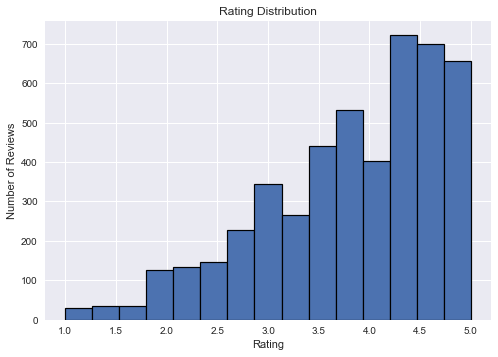

In [13]:
plt.hist(dfs_clean_smaller['Rating'],edgecolor='black', linewidth=1.2, bins=np.linspace(1.0,5.0,16))
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.legend()


plt.show()

In [14]:
# Define a function to perform training and test sets split:

def tt_split(df, y_column, test_size):
    X=df.drop(y_column, 1)
    y=df[y_column]
    return train_test_split(X, y, test_size=test_size, random_state=8)

In [15]:
# Mode l: noted y is not normal distribution. Leave it untransformed in this scenario

# Perform training and testing splits

X_train, X_test, y_train, y_test=tt_split(dfs_clean, 'Rating', 0.8)

# normalize training set

ssX = StandardScaler()
X_train_scaled = ssX.fit_transform(X_train)


model1=sm.OLS(y_train, sm.add_constant(X_train_scaled))
fit1=model1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     33.62
Date:                Fri, 20 Jul 2018   Prob (F-statistic):          7.27e-109
Time:                        16:08:00   Log-Likelihood:                -949.69
No. Observations:                 959   AIC:                             1949.
Df Residuals:                     934   BIC:                             2071.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8173      0.021    179.097      0.000       3.775       3.859
x1            -0.1924      0.025     -7.682      0.000      -0.242      -0.143
x2            -0.0141      0.022     -0.637      0.524      -0.058       0.029
x3             0.0049      0.007      0.666      0.505      -0.009       0.019
x4             0.0035      0.005      0.647      0.518      -0.007       0.014
x5            -0.0035      0.005     -0.647      0.518      -0.014       0.007
x6            -0.0099      0.011     -0.921      0.357      -0.031       0.011
x7            -0.0035      0.005     -0.647      0.518      -0.014       0.007
x8             0.0131      0.012      1.066      0.287      -0.011       0.037
x9            -0.1520      0.135     -1.126      0.260      -0.417       0.113
x10           -0.2003      0.194     -1.034      0.301      -0.580       0.180
x11           -0.1508      0.085     -1.772      0.077      -0.318       0.016
x12           -0.3081      0.214     -1.437      0.151      -0.729       0.113
x13           -0.3505      0.193     -1.814      0.070      -0.730       0.029
x14           -0.1956      0.125     -1.561      0.119      -0.442       0.050
x15           -0.4787      0.239     -2.002      0.046      -0.948      -0.009
x16           -0.3465      0.227     -1.528      0.127      -0.792       0.099
x17           -0.3246      0.144     -2.251      0.025      -0.608      -0.042
x18           -0.3420      0.137     -2.497      0.013      -0.611      -0.073
x19           -0.3038      0.194     -1.567      0.117      -0.684       0.077
x20           -0.3119      0.210     -1.487      0.137      -0.723       0.100
x21           -0.5061      0.233     -2.168      0.030      -0.964      -0.048
x22           -0.3964      0.182     -2.177      0.030      -0.754      -0.039
x23           -0.2914      0.191     -1.522      0.128      -0.667       0.084
x24           -0.2505      0.206     -1.215      0.225      -0.655       0.154
x25           -0.3725      0.195     -1.909      0.057      -0.756       0.010
x26           -0.2100      0.071     -2.967      0.003      -0.349      -0.071
x27           -0.2283      0.084     -2.705      0.007      -0.394      -0.063
x28           -0.6788      0.273     -2.491      0.013      -1.214      -0.144
==============================================================================
Omnibus:                       61.682   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.841
Skew:                          -0.615   Prob(JB):                     9.24e-17
Kurtosis:                       3.579   Cond. No.                     2.28e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is

In [23]:
#diagnostic_plots.diagnostic_plots(dfs_clean.drop('Rating', axis=1), dfs_clean['Rating'], fit1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     30.12
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           4.21e-99
Time:                        16:09:45   Log-Likelihood:                 371.77
No. Observations:                 959   AIC:                            -693.5
Df Residuals:                     934   BIC:                            -571.9
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0715      0.015      4.665      0.000       0.041       0.102
Level of difficulty            -0.0592      0.008     -7.086      0.000      -0.076      -0.043
Total reviews                   0.0082      0.006      1.344      0.179      -0.004       0.020
Student size                 3.963e-05   8.32e-06      4.763      0.000    2.33e-05     5.6e-05
Type_public                     0.1756      0.037      4.720      0.000       0.103       0.249
Type_private                   -0.1041      0.022     -4.737      0.000      -0.147      -0.061
Region_west                     0.2914      0.063      4.635      0.000       0.168       0.415
Region_east                    -0.1041      0.022     -4.737      0.000      -0.147      -0.061
Region_south                   -0.1158      0.026     -4.401      0.000      -0.167      -0.064
Accessible outside class       -0.6907      0.470     -1.469      0.142      -1.613       0.232
Amazing lectures               -0.6326      0.467     -1.355      0.176      -1.549       0.284
Beware of pop quizzes          -0.8790      0.483     -1.819      0.069      -1.827       0.069
Caring                         -0.8033      0.468     -1.716      0.086      -1.722       0.115
Clear grading criteria         -0.9279      0.468     -1.983      0.048      -1.846      -0.010
Extra credit                   -0.8275      0.469     -1.765      0.078      -1.748       0.093
Get ready to read              -1.0310      0.467     -2.208      0.027      -1.947      -0.115
Gives good feedback            -0.8260      0.469     -1.763      0.078      -1.745       0.094
Graded by few things           -1.1026      0.471     -2.342      0.019      -2.027      -0.179
Group projects                 -1.2307      0.471     -2.614      0.009      -2.155      -0.307
Hilarious                      -0.8491      0.466     -1.822      0.069      -1.764       0.065
Inspirational                  -0.8072      0.468     -1.724      0.085      -1.726       0.112
Lecture heavy                  -1.1080      0.467     -2.372      0.018      -2.025      -0.191
Lots of homework               -1.1077      0.469     -2.360      0.018      -2.029      -0.187
Participation matters          -0.8099      0.470     -1.724      0.085      -1.732       0.112
Respected                      -0.7001      0.464     -1.509      0.132      -1.611       0.210
Skip class? you won't pass.    -0.9535      0.469     -2.033      0.042      -1.874      -0.033
So many papers                 -1.5344      0.486     -3.160      0.002      -2.487      -0.581
Test heavy                     -1.3536      0.475     -2.850      0.004      -2.286      -0.422
Tough grader                   -1.3080      0.465     -2.811      0.005      -2.221      -0.395
===========

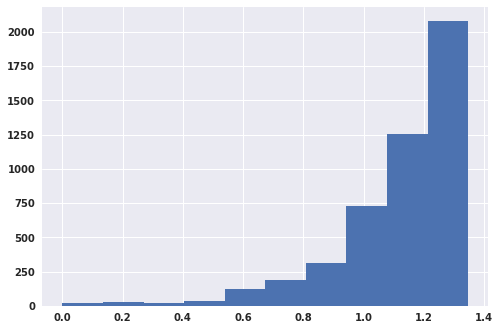

In [20]:
# Model 2: Tested Box transformation of y and noted worse result

from scipy import stats

dfs_box=dfs_clean.copy()
lamb=stats.boxcox_normmax(dfs_box.Rating, brack=(-1.9, 1.9))

dfs_box.Rating=(np.power(dfs_box.Rating,-0.2282)-1)/-0.2282

plt.hist(dfs_box.Rating);


X_train2, X_test2, y_train2, y_test2=tt_split(dfs_box, 'Rating', 0.8)
ssX2 = StandardScaler()
X_train_scaled2 = ssX.fit_transform(X_train2)



model2=sm.OLS(y_train2, sm.add_constant(X_train2))
fit2=model2.fit()
fit2.summary()

In [74]:
# Model 3: Tested log transform of y, and noted worse result

dfs_log=dfs_clean.copy()
dfs_log['Rating']=np.log(dfs_log['Rating'])

X_train3, X_test3, y_train3, y_test3=tt_split(dfs_log, 'Rating', 0.8)
ssX3 = StandardScaler()
X_train_scaled3 = ssX.fit_transform(X_train3)


model3=sm.OLS(y_train3, sm.add_constant(X_train3))
fit3=model3.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     31.17
Date:                Fri, 20 Jul 2018   Prob (F-statistic):          4.51e-102
Time:                        16:19:26   Log-Likelihood:                 144.07
No. Observations:                 959   AIC:                            -238.1
Df Residuals:                     934   BIC:                            -116.5
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0863      0.019      4.439      0.000       0.048       0.124
Level of difficulty            -0.0769      0.011     -7.259      0.000      -0.098      -0.056
Total reviews                   0.0075      0.008      0.963      0.336      -0.008       0.023
Student size                  4.79e-05   1.06e-05      4.539      0.000    2.72e-05    6.86e-05
Type_public                     0.2125      0.047      4.504      0.000       0.120       0.305
Type_private                   -0.1262      0.028     -4.529      0.000      -0.181      -0.072
Region_west                     0.3513      0.080      4.406      0.000       0.195       0.508
Region_east                    -0.1262      0.028     -4.529      0.000      -0.181      -0.072
Region_south                   -0.1388      0.033     -4.159      0.000      -0.204      -0.073
Accessible outside class       -0.8327      0.596     -1.397      0.163      -2.003       0.337
Amazing lectures               -0.7628      0.592     -1.289      0.198      -1.924       0.399
Beware of pop quizzes          -1.1096      0.613     -1.811      0.070      -2.312       0.093
Caring                         -0.9853      0.593     -1.660      0.097      -2.150       0.179
Clear grading criteria         -1.1576      0.593     -1.951      0.051      -2.322       0.007
Extra credit                   -1.0256      0.594     -1.725      0.085      -2.192       0.141
Get ready to read              -1.2853      0.592     -2.171      0.030      -2.447      -0.123
Gives good feedback            -1.0201      0.594     -1.717      0.086      -2.186       0.146
Graded by few things           -1.3895      0.597     -2.327      0.020      -2.561      -0.218
Group projects                 -1.5524      0.597     -2.601      0.009      -2.724      -0.381
Hilarious                      -1.0471      0.591     -1.772      0.077      -2.207       0.113
Inspirational                  -0.9954      0.594     -1.677      0.094      -2.160       0.170
Lecture heavy                  -1.3839      0.592     -2.337      0.020      -2.546      -0.222
Lots of homework               -1.3856      0.595     -2.329      0.020      -2.553      -0.218
Participation matters          -1.0022      0.596     -1.682      0.093      -2.171       0.167
Respected                      -0.8521      0.588     -1.448      0.148      -2.007       0.302
Skip class? you won't pass.    -1.1965      0.595     -2.012      0.044      -2.363      -0.029
So many papers                 -1.9306      0.616     -3.135      0.002      -3.139      -0.722
Test heavy                     -1.7045      0.602     -2.830      0.005      -2.886      -0.523
Tough grader                   -1.6241      0.590     -2.753      0.006      -2.782      -0.466
===========

In [21]:
# model 4 with lasso approach

In [22]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [23]:
X_train, X_test, y_train, y_test=tt_split(dfs_clean_smaller, 'Rating', 0.8)

In [24]:
SSX4=StandardScaler()
X_train_scaled=SSX4.fit_transform(X_train)
X_test_scaled=SSX4.transform(X_test)

In [25]:
# define pipeline

est=make_pipeline(PolynomialFeatures(2), Lasso(1))

In [26]:
est.get_params().keys()

dict_keys(['memory', 'steps', 'polynomialfeatures', 'lasso', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'lasso__alpha', 'lasso__copy_X', 'lasso__fit_intercept', 'lasso__max_iter', 'lasso__normalize', 'lasso__positive', 'lasso__precompute', 'lasso__random_state', 'lasso__selection', 'lasso__tol', 'lasso__warm_start'])

In [27]:
#est.get_params().keys()
#est.set_params(polynomialfeatures__degree=4)

In [28]:
params = {'lasso__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1] , 'polynomialfeatures__degree': [1, 2, 3]}
grid = GridSearchCV(est, param_grid=params, cv=5)
fit=grid.fit(X_train_scaled, y_train)

/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

In [29]:
grid.best_estimator_.get_params()['lasso'].coef_

array([ 0.        , -0.22535961,  0.14365742,  0.22973502,  0.16639805,
        0.0845174 ,  0.15943565,  0.1285289 ,  0.15785578,  0.13537392,
        0.20265492,  0.06205456])

In [30]:
grid.best_params_

{'lasso__alpha': 0.001, 'polynomialfeatures__degree': 1}

In [31]:
grid.score(X_test_scaled, y_test)

0.4057764442229708

In [32]:
X_train.head()

Level of difficulty  Accessible outside class  \
berkeley 692                   3.9                      0.00   
nyu      489                   3.5                      0.00   
uf       1420                  3.0                      0.08   
         4245                  3.3                      0.00   
berkeley 206                   1.9                      0.00   

               Amazing lectures  Caring  Clear grading criteria  \
berkeley 692                0.0    0.00                    0.00   
nyu      489                0.0    0.00                    0.25   
uf       1420               0.0    0.08                    0.00   
         4245               0.0    0.08                    0.00   
berkeley 206                0.0    0.20                    0.00   

               Gives good feedback  Hilarious  Inspirational  \
berkeley 692                  0.00       0.00           0.00   
nyu      489                  0.00       0.00           0.00   
uf       1420                 0.00       0.08           0.25   
         4245                 0.17       0.00           0.08   
berkeley 206                  0.00       0.00           0.40   

               Participation matters  Respected  Skip class? you won't pass.  
berkeley 692                     0.0       0.00                         0.00  
nyu      489                     0.0       0.00                         0.00  
uf       1420                    0.0       0.17                         0.00  
         4245                    0.0       0.00                         0.25  
berkeley 206                     0.0       0.40                         0.00

In [33]:
y_predict=fit.predict(X_test_scaled)

In [34]:
y_residual=y_test-y_predict

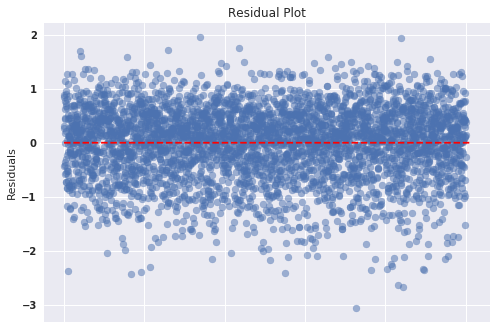

In [35]:
#plt.plot(dfs_clean_smaller['Rating'],edgecolor='black', linewidth=1.2, bins=np.linspace(1.0,5.0,16))
plt.scatter(np.linspace(0,1000,3839), y_residual, alpha=0.5)
plt.plot(np.linspace(0,1010,3839), np.linspace(0,0,3839), 'r--')
plt.title("Residual Plot")
plt.xlabel("")
plt.ylabel("Residuals")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)



plt.show()

In [53]:
# Modle 5 with Ridge model

degree=2
alphas= 1  #[1e-5, 1e-4, 1e-3,1e-2,1e-1]


est2=make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alphas))

In [54]:
est2.get_params().keys()

dict_keys(['memory', 'steps', 'polynomialfeatures', 'ridge', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'ridge__alpha', 'ridge__copy_X', 'ridge__fit_intercept', 'ridge__max_iter', 'ridge__normalize', 'ridge__random_state', 'ridge__solver', 'ridge__tol'])

In [55]:
params2 = {'ridge__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1] , 'polynomialfeatures__degree': [1, 2, 3]}
grid2 = GridSearchCV(est2, param_grid=params2, cv=5)
grid2.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'polynomialfeatures__degree': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [56]:
grid2.best_estimator_.get_params()['ridge'].coef_

array([ 0.        , -0.22503536,  0.14483339,  0.23082068,  0.16745131,
        0.08628523,  0.16073567,  0.1298527 ,  0.15906314,  0.13681713,
        0.20366588,  0.06403286])

In [57]:
grid2.best_params_

{'polynomialfeatures__degree': 1, 'ridge__alpha': 1}

In [58]:
grid2.score(X_test_scaled, y_test)

0.4055806422490368

In [59]:
# Model 6: Elastic Net
from sklearn.linear_model import ElasticNet

In [60]:
degree=2
alphas=1

est3=make_pipeline(PolynomialFeatures(degree), ElasticNet(alpha=alphas))

In [61]:
est3.get_params().keys()

dict_keys(['memory', 'steps', 'polynomialfeatures', 'elasticnet', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'elasticnet__alpha', 'elasticnet__copy_X', 'elasticnet__fit_intercept', 'elasticnet__l1_ratio', 'elasticnet__max_iter', 'elasticnet__normalize', 'elasticnet__positive', 'elasticnet__precompute', 'elasticnet__random_state', 'elasticnet__selection', 'elasticnet__tol', 'elasticnet__warm_start'])

In [62]:
params = {'elasticnet__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1] , 'polynomialfeatures__degree': [1, 2, 3]}
grid3 = GridSearchCV(est3, param_grid=params, cv=5)
grid3.fit(X_train_scaled, y_train)

/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('elasticnet', ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'polynomialfeatures__degree': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [63]:
grid3.best_params_

{'elasticnet__alpha': 0.01, 'polynomialfeatures__degree': 1}

In [64]:
grid3.best_estimator_.get_params()['elasticnet'].coef_

array([ 0.        , -0.22606538,  0.13724594,  0.22296543,  0.16071689,
        0.07571041,  0.15233942,  0.12175314,  0.15159818,  0.12760483,
        0.19684617,  0.05197278])

In [65]:
grid3.score(X_test_scaled, y_test)

0.406398317554983

In [66]:
X_train.head()

Level of difficulty  Accessible outside class  \
berkeley 692                   3.9                      0.00   
nyu      489                   3.5                      0.00   
uf       1420                  3.0                      0.08   
         4245                  3.3                      0.00   
berkeley 206                   1.9                      0.00   

               Amazing lectures  Caring  Clear grading criteria  \
berkeley 692                0.0    0.00                    0.00   
nyu      489                0.0    0.00                    0.25   
uf       1420               0.0    0.08                    0.00   
         4245               0.0    0.08                    0.00   
berkeley 206                0.0    0.20                    0.00   

               Gives good feedback  Hilarious  Inspirational  \
berkeley 692                  0.00       0.00           0.00   
nyu      489                  0.00       0.00           0.00   
uf       1420                 0.00       0.08           0.25   
         4245                 0.17       0.00           0.08   
berkeley 206                  0.00       0.00           0.40   

               Participation matters  Respected  Skip class? you won't pass.  
berkeley 692                     0.0       0.00                         0.00  
nyu      489                     0.0       0.00                         0.00  
uf       1420                    0.0       0.17                         0.00  
         4245                    0.0       0.00                         0.25  
berkeley 206                     0.0       0.40                         0.00

In [67]:
X_final=X_train.drop(['Clear grading criteria', "Skip class? you won't pass."],1)

In [68]:
X_final.columns

Index(['Level of difficulty', 'Accessible outside class', 'Amazing lectures',
       'Caring', 'Gives good feedback', 'Hilarious', 'Inspirational',
       'Participation matters', 'Respected'],
      dtype='object')

In [69]:
X_final.shape

(959, 9)

In [77]:
#diagnostic_plots.diagnostic_plots(dfs_clean_smaller.drop('Rating', axis=1), dfs_clean_smaller['Rating'])